# Laboratorio di Machine Learning: Pre-processing del California Housing Dataset

In questo notebook esploreremo le fasi critiche della preparazione dei dati. Caricheremo il dataset, simuleremo scenari di dati mancanti, analizzeremo le distribuzioni e normalizzeremo le feature per prepararle a un modello di regressione.

### 1. Caricamento del Dataset
Utilizziamo `sklearn.datasets` per importare il California Housing Dataset. Questo dataset contiene informazioni sul valore delle case, reddito, età dell'edificio e altre metriche geografiche per i distretti della California.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

# Caricamento del dataset
california = fetch_california_housing()
df = pd.DataFrame(california.data, columns=california.feature_names)
df['MedHouseVal'] = california.target

# Aggiunta di una variabile categorica fittizia per scopi didattici (Region)
df['Region'] = np.random.choice(['North', 'South', 'East', 'West'], size=len(df))

print("Dataset caricato correttamente.")
df.head()

Dataset caricato correttamente.


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,Region
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,East
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,South
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,East
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,North
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,North


### 2. Simulazione Dati Mancanti
Nella pratica, i dataset raramente sono completi. Qui introduciamo artificialmente dei valori nulli:
- **AveOccup**: 40% di valori mancanti (scenari di perdita grave).
- **HouseAge**: 10% di valori mancanti (scenari di perdita lieve).

In [21]:
np.random.seed(42)

# 40% valori mancanti su AveOccup
mask_40 = np.random.rand(len(df)) < 0.4
df.loc[mask_40, 'AveOccup'] = np.nan

# 10% valori mancanti su HouseAge
mask_10 = np.random.rand(len(df)) < 0.1
df.loc[mask_10, 'HouseAge'] = np.nan

print(f"Valori nulli in AveOccup: {df['AveOccup'].isnull().sum()}")
print(f"Valori nulli in HouseAge: {df['HouseAge'].isnull().sum()}")

Valori nulli in AveOccup: 8235
Valori nulli in HouseAge: 2062


### 3. Analisi Esplorativa (EDA)
Utilizziamo `info()` per verificare i tipi di dato e la presenza di nulli, e `describe()` per osservare le statistiche principali (media, deviazione standard, quartili).

In [22]:
print("--- Info del Dataset ---")
df.info()

print("\n--- Statistiche Descrittive ---")
display(df.describe())

--- Info del Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     18578 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     12405 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
 9   Region       20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB

--- Statistiche Descrittive ---


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,18578.000000,20640.000000,20640.000000,20640.000000,12405.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.585262,5.429000,1.096675,1425.476744,3.089655,35.631861,-119.569704,2.068558
std,1.899822,12.579697,2.474173,0.473911,1132.462122,12.403141,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.428070,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.816598,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.281525,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


### 4. Analisi Variabili Categoriche
Per le variabili categoriche, è fondamentale contare le frequenze delle classi per identificare eventuali sbilanciamenti.

In [23]:
print("Conteggio valori per la variabile 'Region':")
print(df['Region'].value_counts())
print(f"\nNumero di categorie uniche: {df['Region'].nunique()}")

Conteggio valori per la variabile 'Region':
Region
North    5230
East     5175
West     5129
South    5106
Name: count, dtype: int64

Numero di categorie uniche: 4


### 5. Strategia di Gestione Dati Mancanti
**Teoria:**
1. **Eliminazione:** Se una colonna ha troppi dati mancanti (>30-40%), le informazioni restanti potrebbero essere fuorvianti. Meglio eliminare la colonna.
2. **Imputazione Numerica:** Se i dati sono pochi, usiamo la **mediana** se la variabile ha un'alta deviazione standard o outlier (è più robusta), altrimenti la **media**.
3. **Imputazione Categorica:** Si utilizza la **moda** (valore più frequente).

In [24]:
# 1. Eliminiamo AveOccup (40% missing)
df_cleaned = df.drop(columns=['AveOccup'])

# 2. Imputazione HouseAge (10% missing) con Mediana (scelta per stabilità)
median_age = df_cleaned['HouseAge'].median()
df_cleaned['HouseAge'] = df_cleaned['HouseAge'].fillna(median_age)

# 3. Imputazione Categorica (fittizia) con Moda
mode_region = df_cleaned['Region'].mode()[0]
df_cleaned['Region'] = df_cleaned['Region'].fillna(mode_region)

print("Pulizia completata. Nulli rimanenti:")
print(df_cleaned.isnull().sum().sum())

Pulizia completata. Nulli rimanenti:
0


### 6. Matrice di Correlazione
Visualizziamo come le variabili numeriche interagiscono tra loro e con il target. Una forte correlazione positiva/negativa indica una relazione importante per il modello.

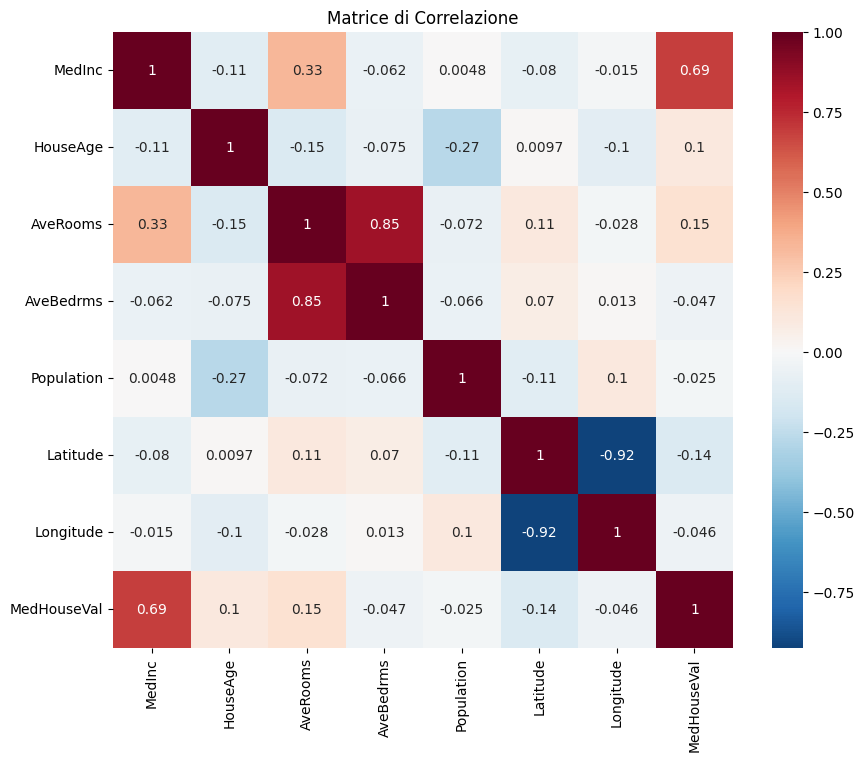

In [25]:
plt.figure(figsize=(10, 8))
numeric_cols = df_cleaned.select_dtypes(include=[np.number])
sns.heatmap(numeric_cols.corr(), annot=True, cmap='RdBu_r', center=0)
plt.title("Matrice di Correlazione")
plt.show()

### 7. Analisi degli Outlier (Boxplot)
I boxplot mostrano la distribuzione dei dati e i punti esterni ai baffi indicano gli outlier, che potrebbero necessitare di trattamento (es. capping o rimozione).

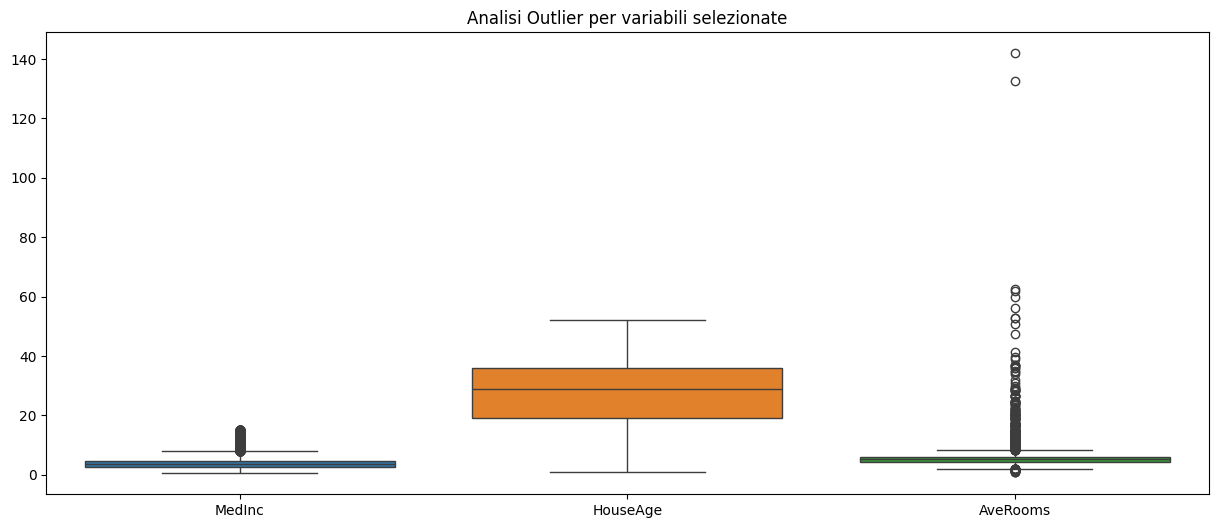

In [26]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_cleaned[['MedInc', 'HouseAge', 'AveRooms']])
plt.title("Analisi Outlier per variabili selezionate")
plt.show()

### 8. Normalizzazione dei Dati
La normalizzazione (StandardScaler) trasforma le variabili in modo che abbiano media 0 e deviazione standard 1. Questo è essenziale per algoritmi come Linear Regression, SVM o Reti Neurali.

In [27]:
scaler = StandardScaler()

# Selezioniamo solo le feature numeriche escludendo il target 'MedHouseVal'
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'Latitude', 'Longitude']

df_scaled = df_cleaned.copy()
df_scaled[features] = scaler.fit_transform(df_cleaned[features])

print("Dati normalizzati.")

Dati normalizzati.


### 9. Describe Finale
Osserviamo le statistiche post-normalizzazione: la media (mean) dovrebbe essere vicina a 0 e la deviazione standard (std) a 1.

In [28]:
print("--- Statistiche Finali post-normalizzazione ---")
display(df_scaled[features].describe().round(4))

--- Statistiche Finali post-normalizzazione ---


,MedInc,HouseAge,AveRooms,AveBedrms,Population,Latitude,Longitude
count,20640.0000,20640.0000,20640.0000,20640.0000,20640.0000,20640.0000,20640.0000
mean,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000
std,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
min,-1.7743,-2.3147,-1.8523,-1.6108,-1.2561,-1.4476,-2.3860
25%,-0.6881,-0.8066,-0.3994,-0.1912,-0.5638,-0.7968,-1.1132
50%,-0.1768,0.0313,-0.0808,-0.1011,-0.2291,-0.6423,0.5389
75%,0.4593,0.6178,0.2520,0.0060,0.2645,0.9730,0.7785
max,5.8583,1.9584,55.1632,69.5717,30.2503,2.9581,2.6253
